In [2]:
%matplotlib notebook

# Specify CUDA device
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = 'gpu'

from jax import jit, config, grad
config.update("jax_enable_x64", True)

# Check we're running on GPU
# from jax.lib import xla_bridge
# print(xla_bridge.get_backend().platform)

import time
import numpy as np
import jax.numpy as jnp
import optax
import jaxopt

from matplotlib import pyplot as plt
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Synthesis_lib as synlib
import scatcovjax.Scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

import scatcovjax.plotting as plot
plot.notebook_plot_format()

# Parameters

In [3]:
sampling = "mw"
multiresolution = True
reality = True

L = 1024
N = 2
J_min = 2

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(f'{J=} {J_max=}')


J=9 J_max=10


# Filters

<IPython.core.display.Javascript object>


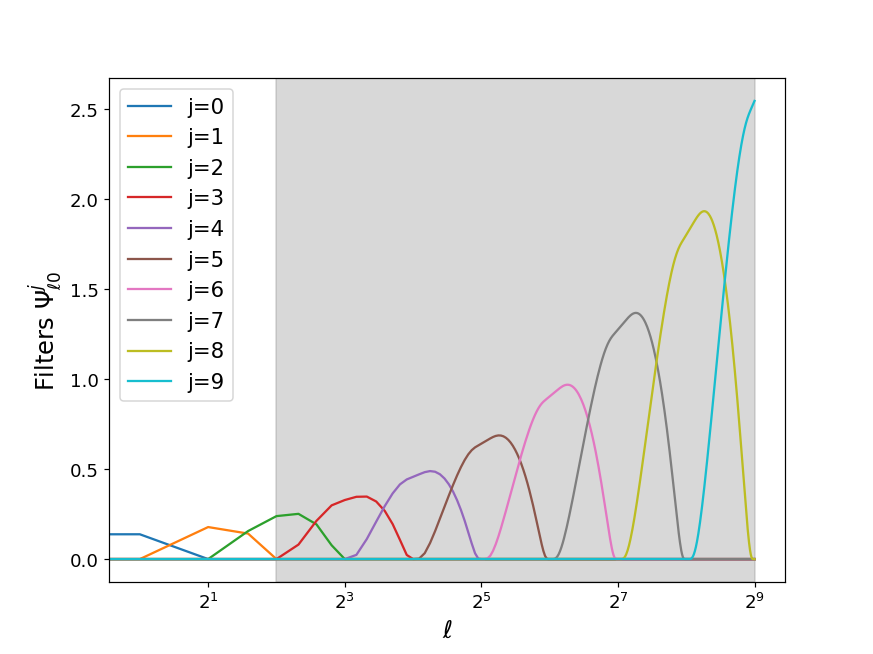

In [15]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=False, m=L-2)
plt.axvspan(2**J_min, 2**J_max, color='grey', alpha=0.3)

# Take the wavelets only, not the scaling function
filters = filters[0]  

# Weights and precomps

In [16]:
weights = scatlib.quadrature(L, J_min, sampling, None, multiresolution)

precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L, N, J_min, 2.0, sampling, None, False,
                                                                     reality, multiresolution)


# Target map

In [5]:
# Save one map for JM
repo = '/travail/lmousset/CosmoGrid/CosmoFiducial_barionified_nside512/'
f_target, flm_target = sphlib.make_CosmoGrid_sky(L, dirmap=repo, run=0, idx_z=10, sampling='healpix', 
                                  nest=False, normalize=True, reality=reality)
print('Target = LSS map')

nside = int(L/2)
print(nside)
np.save(f'/travail/lmousset/Cosmogrid_Hpx_map_nside{nside}_run0_idx10.npy', f_target)

Map at redshift z=0.14677950739860535
Mean and STD: 0.000 and 1.000


2023-09-20 15:17:08.901141: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:246] Failed to make cuFFT batched plan: 8
2023-09-20 15:17:08.901176: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:457] Initialize Params: rank: 1 elem_count: 1996 input_embed: 1996 input_stride: 1 input_distance: 1996 output_embed: 1996 output_stride: 1 output_distance: 1996 batch_count: 1
2023-09-20 15:17:08.901185: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:466] Failed to initialize batched cufft plan with customized allocator: Failed to make cuFFT batched plan.
2023-09-20 15:17:08.901357: E external/org_tensorflow/tensorflow/compiler/xla/status_macros.cc:57] INTERNAL: RET_CHECK failure (external/org_tensorflow/tensorflow/compiler/xla/service/gpu/fft_thunk.cc:143) fft_plan != nullptr Failed to create cuFFT batched plan with scratch allocator
*** Begin stack trace ***
	
	
	
	
	
	
	
*** End stack tr

XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.fft' failed: RET_CHECK failure (external/org_tensorflow/tensorflow/compiler/xla/service/gpu/fft_thunk.cc:143) fft_plan != nullptr Failed to create cuFFT batched plan with scratch allocator.

In [5]:
### Sky
repo = '/travail/lmousset/CosmoGrid/CosmoFiducial_barionified_nside512/'
f_target, flm_target = sphlib.make_CosmoGrid_sky(L, dirmap=repo, run=0, idx_z=10, sampling=sampling, 
                                   nest=False, normalize=True, reality=reality)
print('Target = LSS map')

#f_target, flm_target = sphlib.make_MW_lensing(L, normalize=True, reality=reality)
#print('Target = LSS map')

#f_target, flm_target = sphlib.make_pysm_sky(L, 'cmb', sampling=sampling, nest=False, normalize=True, reality=reality)
#print('Target = CMB map')

# f_target, flm_target = sphlib.make_planet(L, planet, normalize=True, reality=reality)
# print('Target = Planet map')

Map at redshift z=0.14677950739860535
Mean and STD: -0.000 and 1.000
Mean and STD: 0.050 and 0.910
Target = LSS map


In [6]:
### Power spectrum of the target
ps_target = sphlib.compute_ps(flm_target)

### P00 for normalisation
tP00_norm = scatlib.get_P00only(flm_target, L, N, J_min, sampling, None,
                                reality, multiresolution, for_synthesis=False, normalisation=None,
                                filters=filters, quads=weights, precomps=precomps)  # [J][Norient]

### Scat coeffs S1, P00, C01, C11
# P00 is one because of the normalisation
tcoeffs = scatlib.scat_cov_dir(flm_target, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                       filters=filters, quads=weights, precomps=precomps)

tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs  # 1D arrays


 j2=2 Lj2=8

 j2=3 Lj2=16

 j2=4 Lj2=32

 j2=5 Lj2=64

 j2=6 Lj2=128

 j2=7 Lj2=256

 j2=8 Lj2=256

 j2=2 Lj2=8

 j2=3 Lj2=16

 j2=4 Lj2=32

 j2=5 Lj2=64

 j2=6 Lj2=128

 j2=7 Lj2=256

 j2=8 Lj2=256


<IPython.core.display.Javascript object>


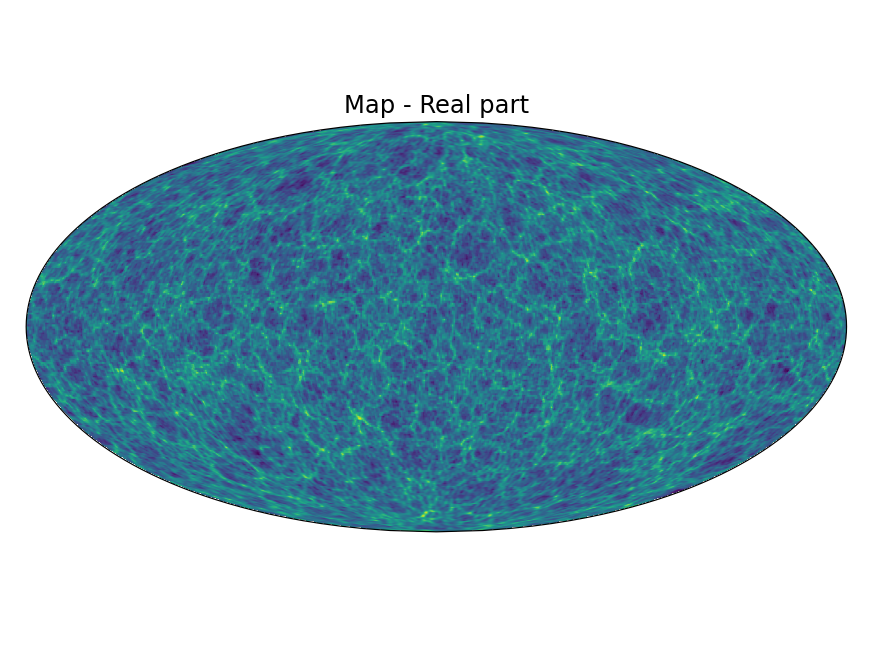

In [7]:
# Plot the map
mx, mn = np.nanmax(np.real(f_target)), np.nanmin(np.real(f_target))
plot.plot_map_MW_Mollweide(np.real(f_target), figsize=(8, 6), vmin=mn, vmax=mx)

In [8]:
print(tP00)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Define the loss

In [9]:
#@jit
#def loss_func_ps_only(flm):
 #   ps = sphlib.compute_ps(flm)
  #  loss = synlib.chi2(ps_target, ps)
   # return loss

@jit
def loss_func_P00_only(flm_float):
    flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    P00_new = scatlib.get_P00only(flm, L, N, J_min, sampling,
                          None, reality, multiresolution, for_synthesis=True,
                          normalisation=tP00_norm, filters=filters,
                          quads=weights, precomps=precomps)
    loss = synlib.chi2(tP00, P00_new)
    return loss


@jit
def loss_func(flm_float):
    # Make complex flm
    flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scatlib.scat_cov_dir(flm, L, N, J_min, sampling,
                                                                        None, reality, multiresolution,
                                                                        for_synthesis=True,
                                                                        normalisation=tP00_norm, filters=filters,
                                                                        quads=weights, precomps=precomps)
    # Control for mean + var
    loss = synlib.chi2(tmean, mean_new)
    loss += synlib.chi2(tvar, var_new)

    # Add S1, P00, C01, C11 losses
    loss += synlib.chi2(tS1, S1_new)
    loss += synlib.chi2(tP00, P00_new)
    loss += synlib.chi2(tC01, C01_new)
    loss += synlib.chi2(tC11, C11_new)

    return loss


# Initial condition

In [10]:
# Gaussian white noise in pixel space with the variance of the target
print(f'{tvar=}')
np.random.seed(42)
if reality:  # Real map
    f = np.sqrt(tvar) * np.random.randn(L, 2 * L - 1).astype(np.float64)
else:
    f = np.sqrt(tvar) * np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j * np.random.randn(L, 2 * L - 1).astype(np.float64)

flm = s2fft.forward_jax(f, L, reality=reality)

# Cut the flm
flm = flm[:, L - 1:] if reality else flm

flm_start = jnp.copy(flm)  # Save the start point as we will iterate on flm

#print('Starting loss', loss_func_P00_only(flm))
# print(scatlib.get_P00only(flm, L, N, J_min, sampling,
#                           None, reality, multiresolution, for_synthesis=True,
#                           normalisation=tP00_norm, filters=filters,
#                           quads=weights, precomps=precomps))

tvar=Array(0.80445943+0.j, dtype=complex128)


<IPython.core.display.Javascript object>


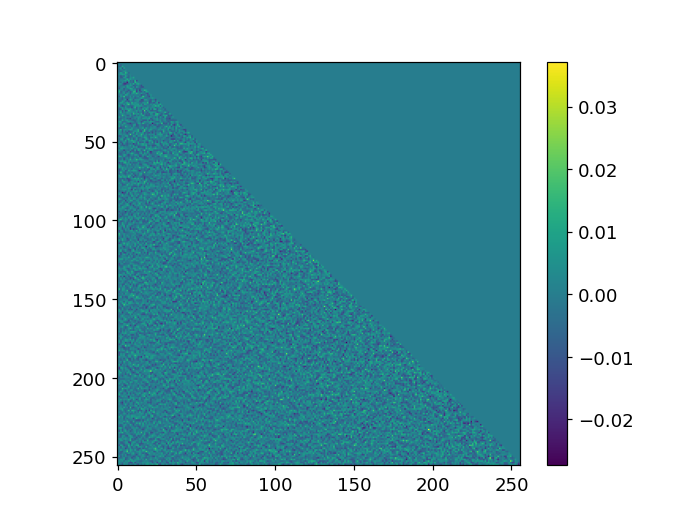

In [11]:
plt.figure()
plt.imshow(np.imag(flm))
plt.colorbar()

# Run the synthesis

### Gradient descent à la main : on veut pas faire ça nous même

- Si je ne mets pas le conjugué, ça diverge.
- Avec le conjugué, ça descend lentement et le PS et la carte ne changent pas bcp

In [16]:
# def fit_brutal(params, loss_func, momentum: float = 2., niter: int = 10, loss_history: list = None):
#     ### Gradient of the loss function
#     grad_loss_func = jit(grad(loss_func))
#
#     if loss_history is None:
#         loss_history = []
#     for i in range(niter):
#         start = time.time()
#         params -= momentum * np.conj(grad_loss_func(params))
#         #params -= momentum * grad_loss_func(params)
#         if i % 10 == 0:
#             end = time.time()
#             loss_value = loss_func(params)
#             loss_history.append(loss_value)
#             print(f"Iter {i}: Loss = {loss_value:.5f}, Momentum = {momentum}, Time = {end - start:.2f} s/iter")
#
#     return params, loss_history

In [17]:
# niter = 400
# momentum = 1
# flm, loss_history = fit_brutal(flm, loss_func_P00_only, momentum=momentum, niter=niter, loss_history=None)

# flm_end = jnp.copy(flm)

### Using Optax

- Avec Adam, ca converge bien et le PS et la carte ont l'air ok

In [18]:
# def fit_optax(params: optax.Params, optimizer: optax.GradientTransformation, loss_func,
#               niter: int = 10, loss_history: list = None) -> optax.Params:
#     ### Gradient of the loss function
#     grad_func = jit(grad(loss_func))
#
#     if loss_history is None:
#         loss_history = []
#     opt_state = optimizer.init(params)
#     for i in range(niter):
#         start = time.time()
#         grads = jnp.conj(grad_func(params))  # Take the conjugate of the gradient
#         #grads = grad_func(params)
#         updates, opt_state = optimizer.update(grads, opt_state, params)
#         params = optax.apply_updates(params, updates)
#         end = time.time()
#         if i % 10 == 0:
#             loss_value = loss_func(params)
#             loss_history.append(loss_value)
#             print(f'Iter {i}, Loss: {loss_value:.10f}, Time = {end - start:.10f} s/iter')
#
#     return params, loss_history

In [59]:
niter = 200
lr = 1e-2
#optimizer = optax.fromage(lr)
optimizer = optax.adam(lr)
#optimizer = optax.adagrad(lr)
flm, loss_history = synlib.fit_optax(flm, optimizer, loss_func_P00_only, niter=niter, loss_history=None)

flm_end = jnp.copy(flm)

### Using Jaxopt

- Methods : GradientDescent ou LBFGS
- Ne marche pas avec des complexes, c'est pour ça que la loss divergeait systématiquement.
- Avec LBFGS, il est bcp + lent que Jaxopt.scipy.minimize('LBFGS')

In [12]:
def fit_jaxopt(params, loss_func, method='LBFGS', niter: int = 10, loss_history: list = None):
    print('Starting loss:', loss_func(params))
    
    if method == 'LBFGS':
        optimizer = jaxopt.LBFGS(fun=loss_func, jit=True)
    elif method == 'GradientDescent':
        optimizer = jaxopt.GradientDescent(fun=loss_func, jit=True)
    
    if loss_history is None:
        loss_history = []
        loss_history.append(loss_func(params))
        
    opt_state = optimizer.init_state(params)
    for i in range(niter):
        start = time.time()
        params, opt_state = optimizer.update(params, opt_state)
        end = time.time()
        if i % 10 == 0:
            loss_value = loss_func(params)
            loss_history.append(loss_value)
            print(f'Iter {i}, Loss: {loss_value:.10f}, Time = {end - start:.10f} s/iter')

    return params, loss_history

In [13]:
flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)])

In [14]:
flm, loss_history = fit_jaxopt(flm_float, loss_func, method='GradientDescent', niter=400, loss_history=None)

# flm_end = jnp.copy(flm)
flm_end = flm[0, :, :] + 1j * flm[1, :, :]

Starting loss: 46.42095411895113
Iter 0, Loss: 33.3927916638, Time = 389.0567836761 s/iter
Iter 10, Loss: 8.2114812192, Time = 3.0150985718 s/iter
Iter 20, Loss: 2.6497419847, Time = 2.4711220264 s/iter
Iter 30, Loss: 0.7221791108, Time = 2.4854414463 s/iter
Iter 40, Loss: 0.2438812662, Time = 3.7298841476 s/iter
Iter 50, Loss: 0.1383952730, Time = 3.7436463833 s/iter
Iter 60, Loss: 0.0972906286, Time = 3.7570908070 s/iter
Iter 70, Loss: 0.0502625531, Time = 2.4722423553 s/iter
Iter 80, Loss: 0.0318735192, Time = 2.4843010902 s/iter
Iter 90, Loss: 0.0292578195, Time = 2.4786369801 s/iter
Iter 100, Loss: 0.0206179353, Time = 2.9683570862 s/iter
Iter 110, Loss: 0.0127884607, Time = 3.7381763458 s/iter
Iter 120, Loss: 0.0100819952, Time = 3.7350420952 s/iter
Iter 130, Loss: 0.0092508996, Time = 3.7314851284 s/iter
Iter 140, Loss: 0.0073482179, Time = 3.7456030846 s/iter
Iter 150, Loss: 0.0052620372, Time = 3.0136024952 s/iter
Iter 160, Loss: 0.0044045530, Time = 2.4795455933 s/iter
Iter 1

### Using jaxopt Scipy

- Methods: CG, Newton-CG, L-BFGS-B
- Ca ne marche pas avec des complexes. Par défaut, il convertit les arrays en float 64. Résultat on a une carte output symmétrique parce que la partie Im des flm est mise à 0. 
- Si on itère sur les parties Re et Im ça marche. 

In [47]:
def fit_jaxopt_Scipy(params, loss_func, method='L-BFGS-B', niter: int = 10, loss_history: list = None):
    
    if loss_history is None:
        loss_history = []
        loss_history.append(loss_func(params))
    
    optimizer = jaxopt.ScipyMinimize(fun=loss_func, method=method, jit=True, maxiter=1)
    
    for i in range(niter):
        start = time.time()
        params, opt_state = optimizer.run(params)
        end = time.time()
        if i % 10 == 0:
            loss_history.append(opt_state.fun_val)
            print(f'Iter {i}, Success: {opt_state.success}, Loss = {opt_state.fun_val}, Time = {end - start:.10f} s/iter')
        
    return params, loss_history

In [92]:
### P00 only
flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)])  # [2, L, L]     

flm, loss_history = fit_jaxopt_Scipy(flm_float, loss_func_P00_only, method='L-BFGS-B', niter=300, loss_history=None)

#flm_end = jnp.copy(flm)
flm_end = flm[0, :, :] + 1j * flm[1, :, :]

In [15]:
### All coeffs
flm = jnp.array([jnp.real(flm), jnp.imag(flm)]) # [2, L, L]          

flm, loss_history = fit_jaxopt_Scipy(flm, loss_func, method='L-BFGS-B', niter=300, loss_history=None)

#flm_end = jnp.copy(flm)
flm_end = flm[0, :, :] + 1j * flm[1, :, :]

Iter 0, Success: False, Loss = 14.534435688922205, Time = 273.4791598320 s/iter
Iter 10, Success: False, Loss = 2.087988822151156, Time = 4.9769644737 s/iter
Iter 20, Success: False, Loss = 0.2326396626316923, Time = 6.2398819923 s/iter
Iter 30, Success: False, Loss = 0.119321423825314, Time = 2.9020557404 s/iter
Iter 40, Success: False, Loss = 0.11060457744074748, Time = 2.9062898159 s/iter
Iter 50, Success: False, Loss = 0.09514824859419112, Time = 2.9489369392 s/iter
Iter 60, Success: False, Loss = 0.06654770024428805, Time = 2.9604301453 s/iter
Iter 70, Success: False, Loss = 0.040310565378411656, Time = 3.6980459690 s/iter
Iter 80, Success: False, Loss = 0.029082891848013888, Time = 2.9473967552 s/iter
Iter 90, Success: False, Loss = 0.026607902110839743, Time = 2.9391603470 s/iter
Iter 100, Success: False, Loss = 0.025136006965041896, Time = 2.9505198002 s/iter
Iter 110, Success: False, Loss = 0.019572463570474267, Time = 2.9248828888 s/iter
Iter 120, Success: False, Loss = 0.017

In [52]:
### P00 and then all coeffs
flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)]) # [2, L, L]          

flm, loss_historyP00 = fit_jaxopt_Scipy(flm_float, loss_func_P00_only, method='L-BFGS-B', niter=300, loss_history=None)

flm, loss_history = fit_jaxopt_Scipy(flm, loss_func, method='L-BFGS-B', niter=300, loss_history=loss_historyP00)

#flm_end = jnp.copy(flm)
flm_end = flm[0, :, :] + 1j * flm[1, :, :]


Iter 0, Success: False, Loss = 9.702923071665147, Time = 17.6179962158 s/iter
Iter 10, Success: False, Loss = 1.5691616781817677, Time = 0.5419459343 s/iter
Iter 20, Success: False, Loss = 0.6132913707044202, Time = 0.5414667130 s/iter
Iter 30, Success: False, Loss = 0.05928260833642139, Time = 0.5406813622 s/iter
Iter 40, Success: False, Loss = 0.019127084384377036, Time = 1.1308889389 s/iter
Iter 50, Success: False, Loss = 0.000989697832159677, Time = 0.5421109200 s/iter
Iter 60, Success: False, Loss = 0.0005329782708832818, Time = 0.6728842258 s/iter
Iter 70, Success: False, Loss = 0.0004188431050710625, Time = 1.2045726776 s/iter
Iter 80, Success: False, Loss = 2.551608749531533e-05, Time = 0.6711707115 s/iter
Iter 90, Success: False, Loss = 1.4498553478574686e-05, Time = 0.4178006649 s/iter
Iter 100, Success: False, Loss = 6.4004526152696586e-06, Time = 0.6728122234 s/iter
Iter 110, Success: False, Loss = 2.637685906711299e-06, Time = 0.4160907269 s/iter
Iter 120, Success: False, 

In [47]:
# plt.figure()
# plt.title('flm_end Im part')
# plt.imshow(np.imag(flm_end))
# plt.colorbar()

# Check the synthesis

In [15]:
# Coeffs

scoeffs = scatlib.scat_cov_dir(flm_start, L, N, J_min, sampling, None,
                           reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                           filters=filters, quads=weights, precomps=precomps)
ecoeffs = scatlib.scat_cov_dir(flm_end, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                       filters=filters, quads=weights, precomps=precomps)


tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs
smean, svar, sS1, sP00, sC01, sC11 = scoeffs
emean, evar, eS1, eP00, eC01, eC11 = ecoeffs

In [16]:
print(flm_target.shape, flm_start.shape, flm_end.shape)

(256, 256) (256, 256) (256, 256)


In [17]:
flm_target

Array([[-1.95253227e-16+0.j        ,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        , ...,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [-7.20775431e-02+0.j        , -3.65707161e-02-0.04917365j,
         0.00000000e+00+0.j        , ...,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 7.25817654e-02+0.j        , -3.06321740e-02-0.09314236j,
        -3.97092380e-02+0.02063355j, ...,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       ...,
       [ 2.44715259e-03+0.j        ,  6.98354966e-03-0.00609037j,
        -1.10703431e-02-0.00523515j, ...,  8.66347193e-04-0.00418811j,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 1.31185064e-03+0.j        ,  1.37534651e-03+0.00496223j,
         3.06377926e-03-0.00119829j, ...,  4.83666130e-03-0.00245996j,
        -2.23772348e-03+0.00421251j

In [18]:
### Cut the flm that are not contrained
flm_target = flm_target.at[0: 2**J_min + 1, :].set(0. + 0.j)

In [19]:
flm_target

Array([[ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       ...,
       [ 0.00244715+0.j        ,  0.00698355-0.00609037j,
        -0.01107034-0.00523515j, ...,  0.00086635-0.00418811j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.00131185+0.j        ,  0.00137535+0.00496223j,
         0.00306378-0.00119829j, ...,  0.00483666-0.00245996j,
        -0.00223772+0.00421251j,  0.        +0.j        ],
       [ 0.00066657+0.j        , -0.00093729-0.00506774j,
        -0.00326489+0.00890074

In [20]:
# Make the maps
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
f_start = s2fft.inverse_jax(flm_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_end, L, reality=reality)

# Mean and var

In [21]:
print('Mean:', tmean, smean, emean)
print('Var:', tvar, svar, evar)

Mean: 5.507991831180309e-17 0.0018398634137463358 0.0003211371494104876
Var: (0.8044594257664267+0j) (0.49999953107573125+0j) (0.8018620627291658+0j)


### Plot the loss

<IPython.core.display.Javascript object>


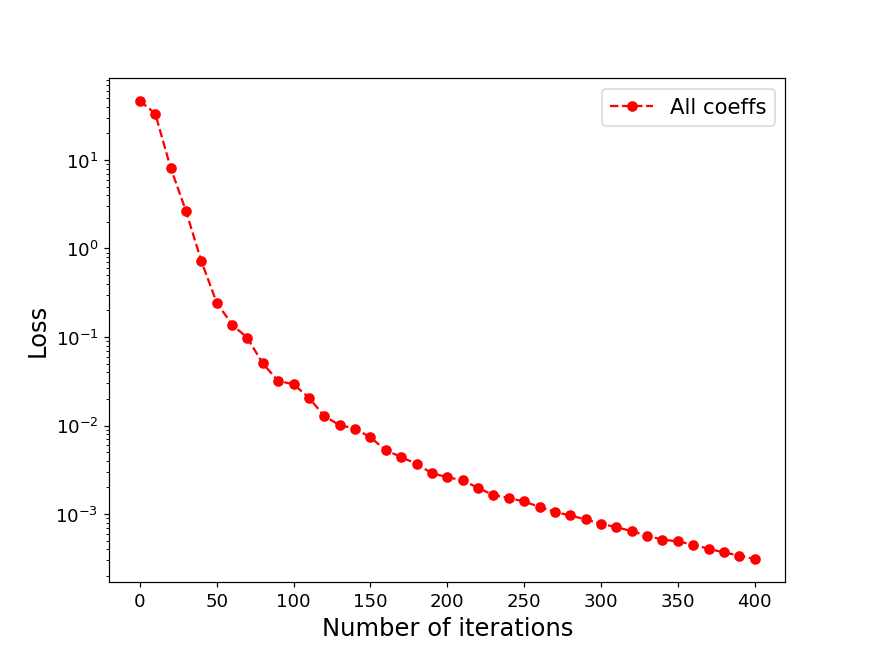

In [22]:
nit1 = 0
nit2 = 400
step = 10

plt.figure(figsize=(8, 6))
#plt.plot(np.arange(0, nit1+1, step), loss_history[:int(nit1/step)+1], 'bo--', label='P00 only')
# plt.plot(np.arange(nit1, nit1 + nit2, step), loss_history[int(nit2/step)+1:], 'ro--', label='All coeffs')
plt.plot(np.arange(nit1, nit1 + nit2 + 1, step), loss_history, 'ro--', label='All coeffs')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.legend()

<IPython.core.display.Javascript object>


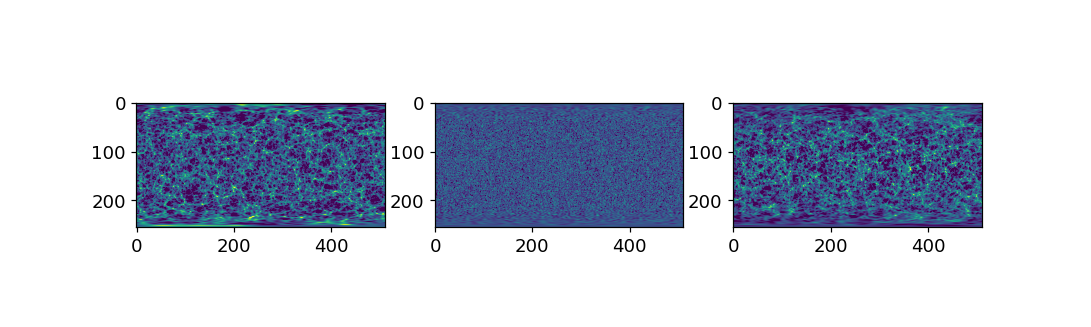

In [23]:
#mn, mx = np.nanmin(f_target), np.nanmax(f_target)
#mn, mx = -1, 3
#mn, mx = None, None
mn, mx = -1, 3


fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
ax1.imshow(np.real(f_target), vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(np.real(f_start), vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

<IPython.core.display.Javascript object>


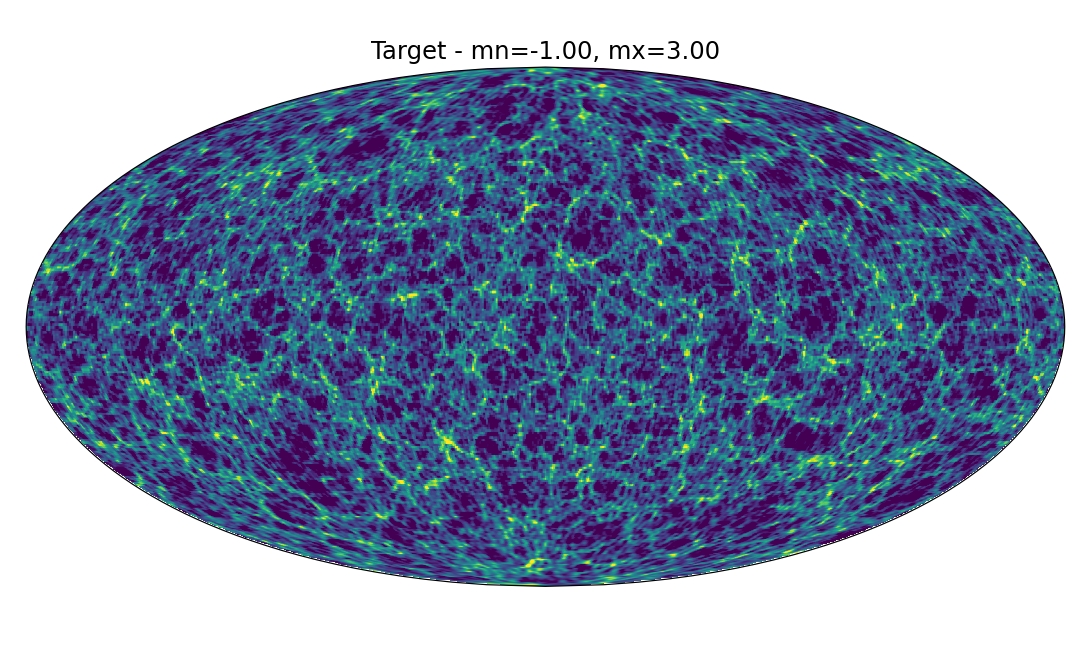

In [24]:
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, title=f'Target - {mn=:.2f}, {mx=:.2f}', figsize=(10, 6))

In [25]:
print(np.min(f_end), np.max(f_end))

-3.383718377891297 4.557602564779323


<IPython.core.display.Javascript object>


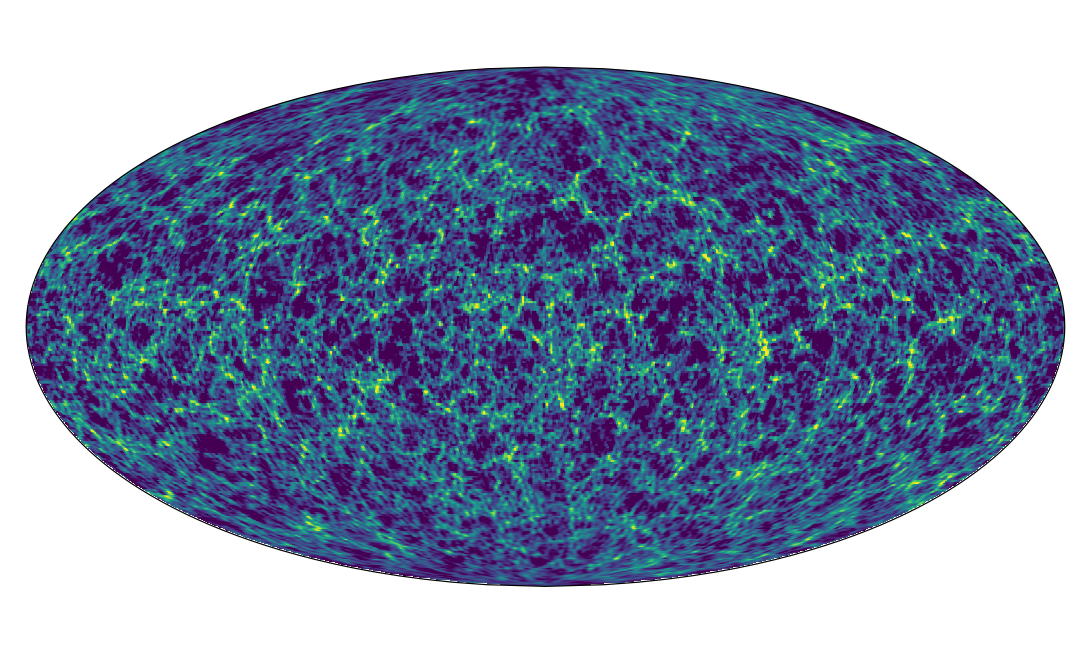

In [27]:
plot.plot_map_MW_Mollweide(f_end, vmin=-1, vmax=3, title='', figsize=(10, 6))#f'End - {mn=:.2f}, {mx=:.2f}', )

### Power spectrum

<IPython.core.display.Javascript object>


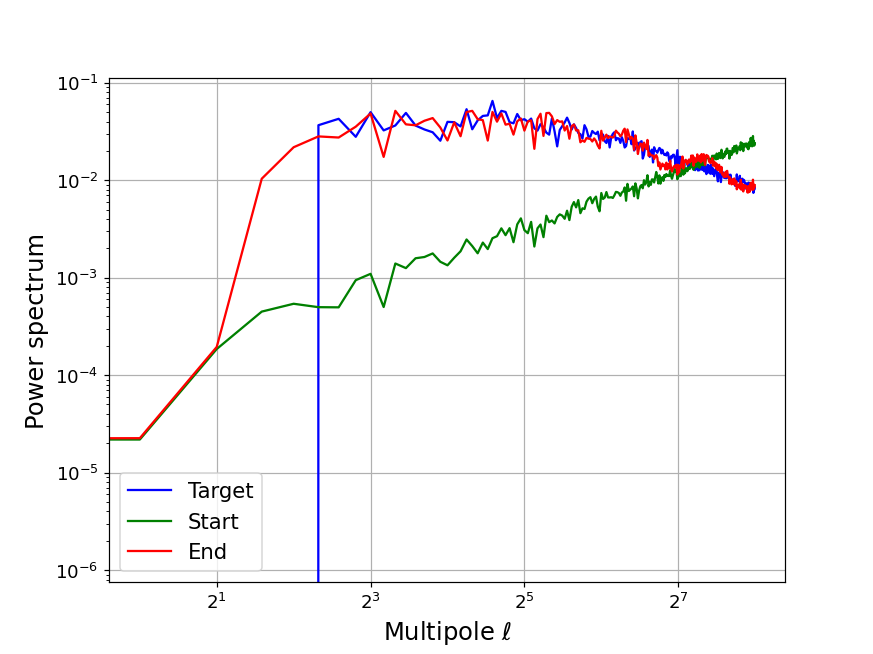

In [30]:
ps_target = sphlib.compute_ps(flm_target)
ps_start = sphlib.compute_ps(flm_start)
ps_end = sphlib.compute_ps(flm_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_start, 'g', label="Start")
plt.plot(ps_end, 'r', label="End")
plt.yscale("log")
plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
#plt.xlim(2, 64)
#plt.ylim(1e-4, 1)
plt.legend()

### Plot the coefficients

<IPython.core.display.Javascript object>


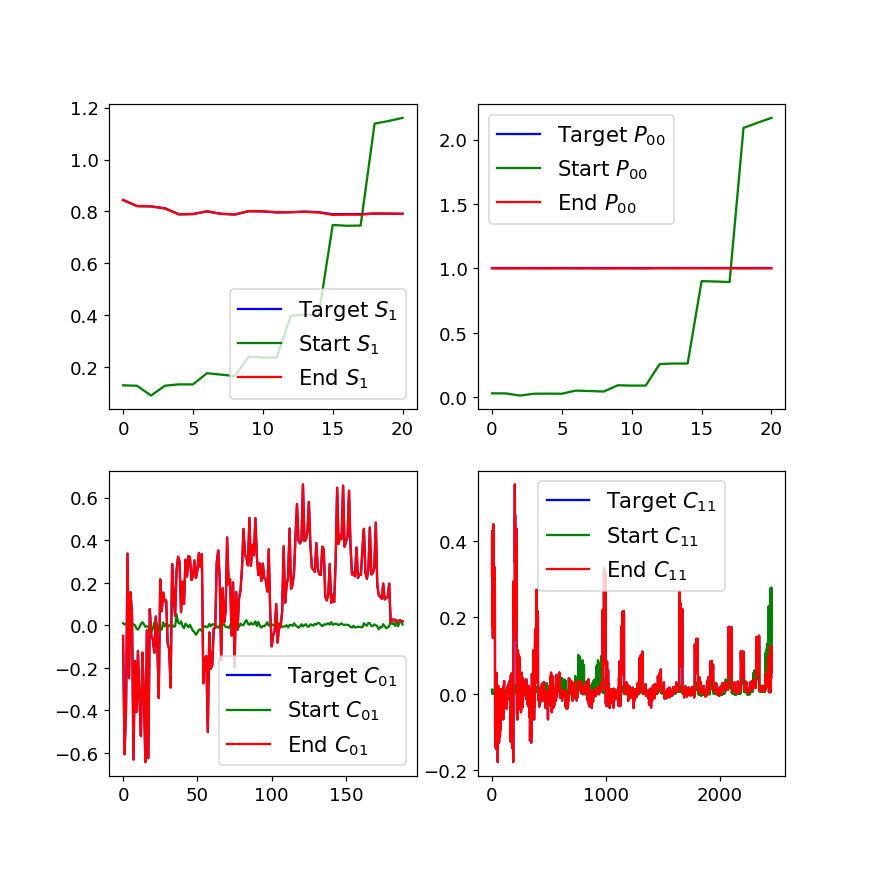

In [29]:
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue')

plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green')

plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red')